<a href="https://colab.research.google.com/github/ContiPaolo/Multifidelity-Tutorial/blob/main/MF_POD_Burger's1D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Multi-fidelity reduced-order modeling on Groundwater's flow - Darcy equation**

#### We aim to create a reduced-order surrogate model that enables the efficient recovery of high-fidelities solutions parameter variations, starting from their low-fidelity counterparts.

#### We consider a data-driven strategy that combines a coarser FEM solver with multi-fidelity neural network surrogates.


#### Import libraries

In [5]:
import numpy as np
#import matplotlib as plt
from matplotlib import pyplot as plt
import pandas as pd 
from tensorflow.keras.optimizers import Adam,Nadam,Adamax
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.models import load_model
from sklearn.utils import extmath

#######################     CONFIGURATIONS     ##########################
seed = 29
train = True
save = True

# DATASET 
The dataset has been developed using fenics library, it is composed of 64000 samples divided in 90% training and 10% testing.\
The input (or X) are the 64 first component of the Karhunen-Loève (KL) decompositions. \
These eigenmodes allow to paratetrize a random field in the most accurate way.

In [14]:
X_train = np.hstack((np.loadtxt('./data/X_train.csv', delimiter=','),  np.loadtxt('./data/X_train_pod.csv', delimiter=',')[:,0:10] ))
y_train = np.loadtxt('./data/y_train.csv', delimiter=',')

X_test = np.hstack((np.loadtxt('./data/X_test.csv', delimiter=','), np.loadtxt('./data/X_test_pod.csv', delimiter=',')[:,0:10] ))
y_test = np.loadtxt('./data/y_test.csv', delimiter=',')

In [15]:
n_c = X_train.shape[1]
n_c

74

The output: 25 sensors are used to record the hydraulic pressure in the domain $\Omega$ \
The sensors are distributed on a grid with positions [0.1, 0.3, 0.5, 0.7, 0.9]



#### (4ii) Training Fully connected neural network surrogate model

In [18]:
Training = False


# Define the learning rate scheduler function
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return max(lr * 0.98, 1e-6)

# Initialize the neural network model
model = Sequential()

# Add layers to the model
model.add(Dense(256, input_shape=(n_c,), activation='gelu'))
model.add(Dense(256, activation='gelu'))
model.add(Dense(256, activation='gelu'))
model.add(Dense(25, activation='linear'))


if Training:
    # Compile the model
    initial_learning_rate = 0.001
    optimizer = Adam(learning_rate=initial_learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    # Define the learning rate scheduler callback
    lr_scheduler = LearningRateScheduler(scheduler)

    # Train the model
    history = model.fit(X_train, y_train, 
                    epochs=1500, 
                    batch_size=64, 
                    validation_data=(X_test, y_test), 
                    callbacks=[lr_scheduler])
    
    model.save('./models/model_HF_POD.keras')

model = load_model('./models/model_HF_POD_2.keras')



/Users/lucacaroselli/miniconda3/envs/myenv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


I0000 00:00:1720807895.338058 5343857 service.cc:145] XLA service 0x2c7498720 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1720807895.338303 5343857 service.cc:153]   StreamExecutor device (0): Host, Default Version


200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 630us/step - loss: 8.0189e-06


I0000 00:00:1720807895.580007 5343857 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Test accuracy: 8.080459338088986e-06
Test rmse: 0.002842614876850008


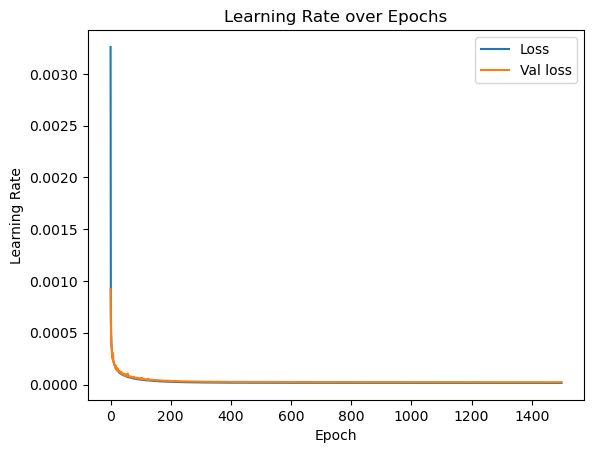

In [19]:
# Evaluate the model on the test set
test_loss = model.evaluate(x=X_test, y=y_test)

# Print the test accuracy
print(f"Test accuracy: {test_loss}")
print(f"Test rmse: {np.sqrt(test_loss)}")

# Optional: Plotting the learning rate and accuracy
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Val loss')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.title('Learning Rate over Epochs')
plt.legend()
plt.show()



Se how it is able to prodict 

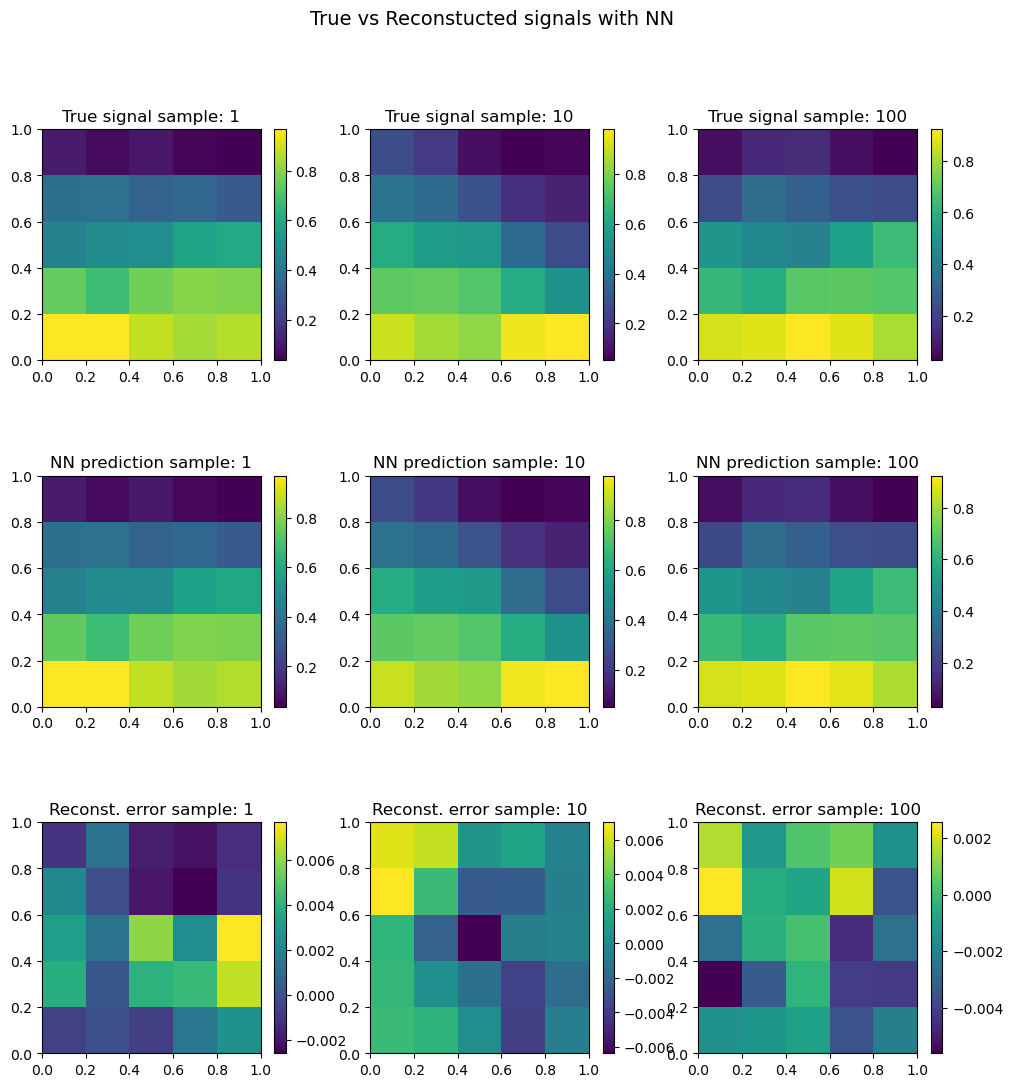

In [22]:
# Define the sampling points.
x_data = y_data = np.array([0.1, 0.3, 0.5, 0.7, 0.9])
# Grid to plot the basis 
X,Y = np.meshgrid(x_data, y_data)

samples = [ 1, 10, 100]
#Plot POD coefficients: LF vs HF
fig = plt.figure(figsize=(12,12))
plt.subplots_adjust(hspace=0.5)
title = 'True vs Reconstucted signals with NN'
fig.suptitle(title, fontsize=14)

for mode in range(3):
    ax = fig.add_subplot(331 + mode)
    pcm = plt.pcolormesh(X, Y, y_test[mode, :].reshape((5, 5)))
    ax.title.set_text('True signal sample: ' + str(samples[mode]))
    plt.colorbar(pcm, ax=ax)
    
    ax = fig.add_subplot(331 + mode + 3)
    reconstructed_sample = np.array(model(X_test[mode, :].reshape((1, 74)))).reshape((5, 5))
    err = y_test[mode, :].reshape(5, 5) - reconstructed_sample
    pcm = plt.pcolormesh(X, Y, reconstructed_sample.reshape((5, 5)))
    ax.title.set_text('NN prediction sample: ' + str(samples[mode]))
    plt.colorbar(pcm, ax=ax)
    
    ax = fig.add_subplot(331 + mode + 6)
    pcm = plt.pcolormesh(X, Y, err)
    ax.title.set_text('Reconst. error sample: ' + str(samples[mode]))
    plt.colorbar(pcm, ax=ax)
